In [2]:
import pandas as pd
import os.path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv('results/monitoring-20230713.csv', sep='\t')
keys_as_float = ['tmp', 'val', 'config', 'sb_oc', 'sb_unused']
for key in keys_as_float: dataset[key] = dataset[key].apply(lambda x : None if x == 'None' else float(x))
dataset['time'] = dataset['tmp'] / 60

/tmp/ipykernel_8854/356828458.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('results/monitoring-20230713.csv', sep='\t')


In [3]:
dataset.head()

,tmp,rec,res,val,config,subset,vm_uuid,vm_cmn,sb_oc,sb_unused,sb_dsc,time
0,0.0,global,cpu,NaN,231.0,None,None,None,NaN,NaN,None,0.0
1,0.0,subset,cpu,NaN,8.0,subset-1.0,None,None,1.0,0.0,"{""res_list"": [{""cpu_id"": 25, ""numa_node"": 0, ""...",0.0
2,0.0,vm,cpu,NaN,8.0,subset-1.0,e2366680-25e0-46fc-bbce-23334f850770,vmtest,1.0,NaN,None,0.0
3,0.0,global,mem,0.01418,1031742.0,None,None,None,NaN,NaN,None,0.0
4,0.0,subset,mem,0.01418,14336.0,subset-1,None,None,1.0,0.0,"{""res_list"": [[0, 14336]], ""consumer_list"": [{...",0.0


# Investigate global usage

In [3]:
overall = dataset.loc[dataset['rec'] == 'global']
overall_cpu = overall.loc[overall['res'] == 'cpu']
overall_mem = overall.loc[overall['rec'] == 'mem']

In [4]:
# Convert percent to CPU cores
pd.options.mode.chained_assignment = None  # default='warn'
overall_cpu['cores'] = overall_cpu['val'] * 256

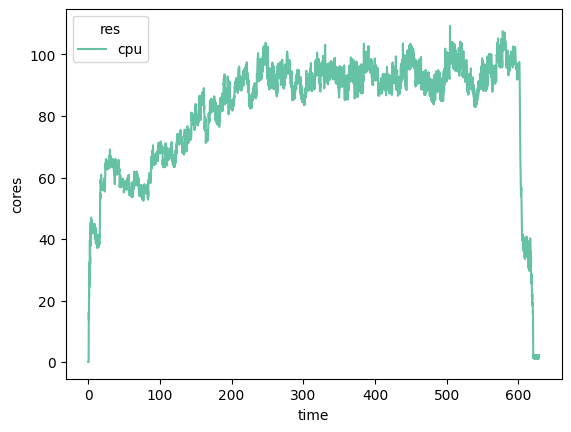

In [5]:
palette = sns.color_palette("Set2", overall_cpu['res'].nunique())

g_val = sns.lineplot(data=overall_cpu, x='time', y='cores', hue='res', palette=palette)

# Investigate subsets usage

In [6]:
subsets = dataset.loc[dataset['rec'] == 'subset']
subsets_cpu = subsets.loc[subsets['res'] == 'cpu']
subsets_mem = subsets.loc[subsets['res'] == 'mem']

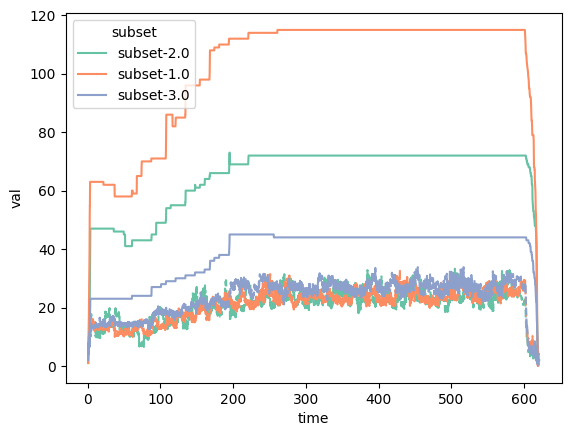

In [7]:
palette = sns.color_palette("Set2", subsets_cpu['subset'].nunique())
# todo Hue_order
g_val = sns.lineplot(data=subsets_cpu, x='time', y='val', hue='subset', linestyle ='--', palette=palette, legend=False)
g_config = sns.lineplot(data=subsets_cpu, x='time', y='config', hue='subset', palette=palette)

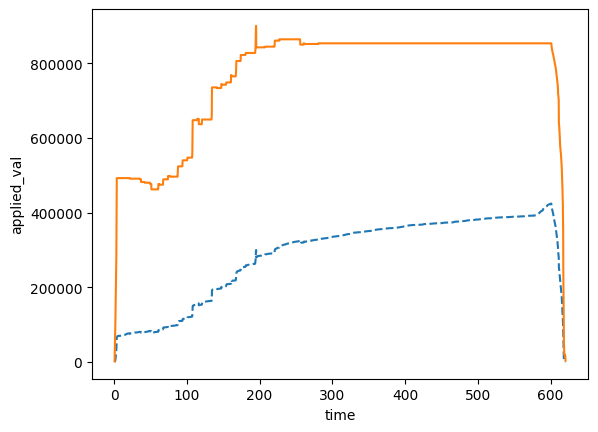

In [20]:
palette = sns.color_palette("Set2", subsets_mem['subset'].nunique())
subsets_mem['applied_val'] = subsets_mem['val']*subsets_mem['config']
# todo Hue_order
g_val = sns.lineplot(data=subsets_mem, x='time', y='applied_val', linestyle ='--')
g_val = sns.lineplot(data=subsets_mem, x='time', y='config')

# Investigate VM usage

In [9]:
vm = dataset.loc[dataset['rec'] == 'vm']
vm_cpu = vm.loc[vm['res'] == 'cpu']
vm_mem = vm.loc[vm['res'] == 'mem']

In [10]:
# Convert percent to CPU cores
pd.options.mode.chained_assignment = None  # default='warn'
vm_cpu['cores'] = vm_cpu['val'] * vm_cpu['config']

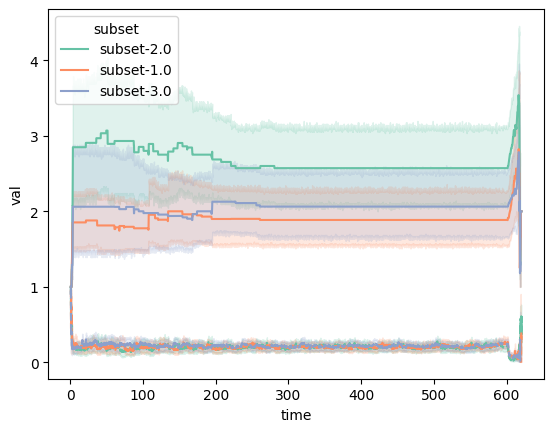

In [11]:
palette = sns.color_palette("Set2", vm_cpu['subset'].nunique())
# todo Hue_order
g_val = sns.lineplot(data=vm_cpu, x='time', y='val', hue='subset', linestyle ='--', palette=palette, legend=False)
g_config = sns.lineplot(data=vm_cpu, x='time', y='config', hue='subset', palette=palette)

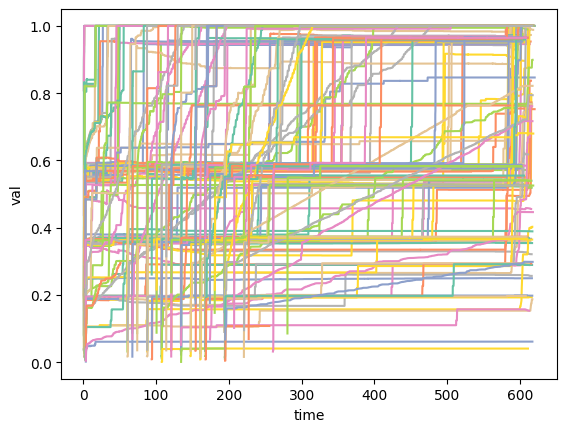

In [12]:
palette = sns.color_palette("Set2", vm_cpu['vm_uuid'].nunique())

g_val = sns.lineplot(data=vm_mem, x='time', y='val', hue='vm_uuid', palette=palette, legend=False)

# Dive into subset configuration

In [13]:
import json
subsets_unarchived = subsets
example = json.loads(subsets_unarchived['sb_dsc'].iloc[0])
print(len(example['consumer_list']))

1


In [14]:
subsets_unarchived['list_vm']  = subsets_unarchived['sb_dsc'].apply(lambda x : json.loads(x)['consumer_list'])
subsets_unarchived['count_vm'] = subsets_unarchived['sb_dsc'].apply(lambda x : len(json.loads(x)['consumer_list']))

/tmp/ipykernel_8854/75521460.py:3: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  g_val = sns.lineplot(data=subsets_unarchived.loc[subsets_unarchived['res'] == 'cpu'], x='time', y='count_vm', hue='res', palette=palette)


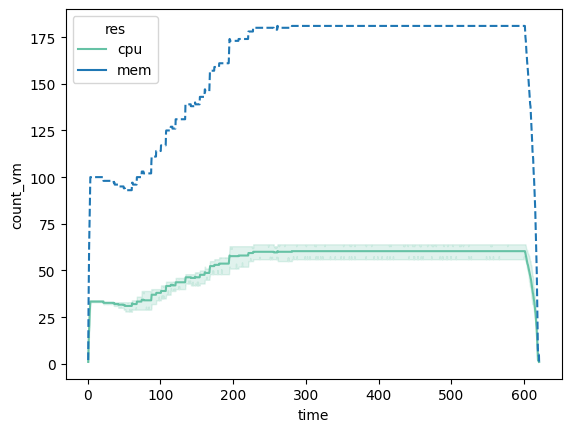

In [15]:
palette = sns.color_palette("Set2", subsets_unarchived['res'].nunique())
# todo Hue_order
g_val = sns.lineplot(data=subsets_unarchived.loc[subsets_unarchived['res'] == 'cpu'], x='time', y='count_vm', hue='res', palette=palette)
g_val = sns.lineplot(data=subsets_unarchived.loc[subsets_unarchived['res'] == 'mem'], x='time', y='count_vm', hue='res', linestyle='--')

# Investigate predictor performance

In [163]:
predictor = pd.read_csv('debug/predictor.csv')
for key in predictor.keys(): predictor[key] = predictor[key].apply(lambda x : float(x) if x != 'None' else None)

In [12]:
predictor.head()

,timestamp,prediction,resources,usage
0,60.0,NaN,6.0,5.454915
1,75.0,6.0,6.0,2.648536
2,90.0,6.0,6.0,3.417470
3,105.0,6.0,6.0,2.329599
4,120.0,6.0,6.0,3.307658


<Axes: xlabel='timestamp', ylabel='prediction'>

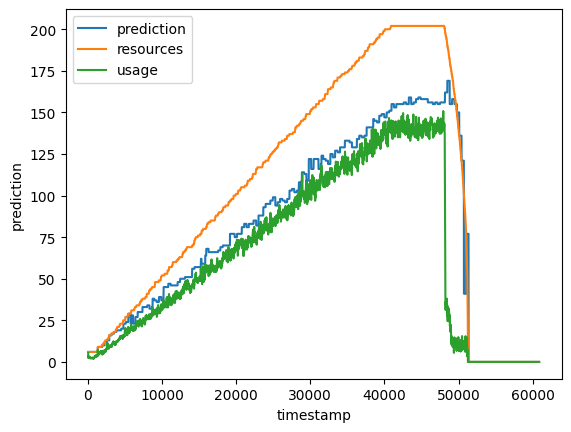

In [164]:
sns.lineplot(data=predictor, x='timestamp', y='prediction', label='prediction')
sns.lineplot(data=predictor, x='timestamp', y='resources', label='resources')
sns.lineplot(data=predictor, x='timestamp', y='usage', label='usage')

(-20.0, 10.0)

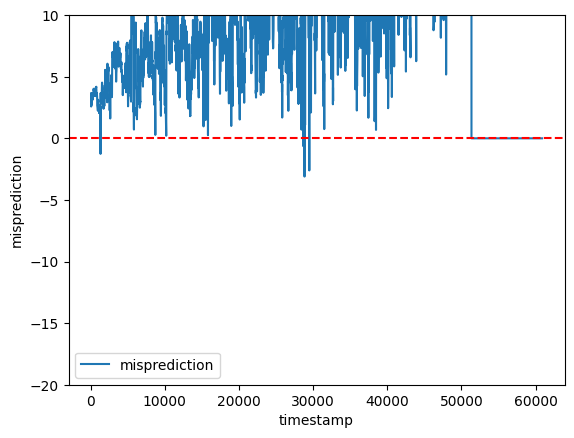

In [165]:
predictor['misprediction'] = predictor['prediction'] - predictor['usage']
g = sns.lineplot(data=predictor, x='timestamp', y='misprediction', label='misprediction')
plt.axhline(y=0.0, color='r', linestyle='--')
g.set_ylim(-20, 10)
#g.set_xlim(0, 7200)